<span style="color: green; font-size: 40px; font-weight: bold;">Lab 3 (Classificação Binária com RandomForest e PySpark) </span>

<br> <br>

# Prevendo Pagamento de Empréstimos Bancários

<br>

### Contexto

Neste projeto, vamos explorar um cenário crucial no setor financeiro: a **previsão de pagamento de empréstimos bancários**. O objetivo é construir um modelo preditivo que, utilizando dados históricos sobre clientes e suas interações com o banco, seja capaz de prever se um cliente irá pagar ou não um empréstimo. Este projeto será desenvolvido desde a concepção do problema de negócio até a entrega de um modelo preditivo, utilizando técnicas de Machine Learning com PySpark, especificamente o algoritmo RandomForest.

<br>

### Objetivo

O objetivo deste projeto é **construir um modelo de Machine Learning capaz de prever se um cliente pagará ou não um empréstimo bancário**. O modelo utilizará dados históricos de clientes, como idade, profissão, estado civil, nível educacional, saldo bancário, e outros fatores relevantes para fazer essa previsão.

<br>

### Pergunta de Negócio Principal
> "Como podemos prever se um cliente irá pagar ou não um empréstimo bancário usando dados históricos de clientes?"

<br>

### Entregável

O entregável deste projeto será um **modelo de Machine Learning treinado para prever o pagamento de empréstimos bancários**. O modelo será desenvolvido utilizando dados históricos e será capaz de fazer previsões com base em novos dados de entrada. O processo incluirá a concepção do problema de negócio, preparação dos dados, desenvolvimento do modelo, e a entrega do modelo preditivo.

<br>

### Sobre o Conjunto de Dados

Os dados utilizados neste projeto abrangem diversas características dos clientes bancários, incluindo idade, profissão, estado civil, nível educacional, saldo bancário, entre outros. A variável de pagamento será a variável alvo (dependente) e as demais variáveis serão candidatas a features (variáveis preditoras ou independentes).

Para este projeto, utilizaremos o conjunto de dados "bank.csv", que contém informações detalhadas sobre clientes bancários e suas interações com o banco.

<br>
<table border="2">
  <tr>
    <th style="text-align: center; font-size: 16px;">Nome da Coluna</th>
    <th style="text-align: center; font-size: 16px;">Tipo de Dado</th>
    <th style="text-align: center; font-size: 16px;">Descrição</th>
  </tr>
  <tr>
    <td>age</td>
    <td>integer</td>
    <td>Idade do cliente.</td>
  </tr>
  <tr>
    <td>job</td>
    <td>string</td>
    <td>Profissão do cliente.</td>
  </tr>
  <tr>
    <td>marital</td>
    <td>string</td>
    <td>Estado civil do cliente.</td>
  </tr>
  <tr>
    <td>education</td>
    <td>string</td>
    <td>Nível educacional do cliente.</td>
  </tr>
  <tr>
    <td>default</td>
    <td>string</td>
    <td>Se o cliente possui histórico de inadimplência.</td>
  </tr>
  <tr>
    <td>balance</td>
    <td>integer</td>
    <td>Saldo bancário do cliente.</td>
  </tr>
  <tr>
    <td>housing</td>
    <td>string</td>
    <td>Se o cliente possui crédito imobiliário.</td>
  </tr>
  <tr>
    <td>loan</td>
    <td>string</td>
    <td>Se o cliente possui outros empréstimos.</td>
  </tr>
  <tr>
    <td>contact</td>
    <td>string</td>
    <td>Tipo de contato usado para comunicação.</td>
  </tr>
  <tr>
    <td>day</td>
    <td>integer</td>
    <td>Dia do mês em que o contato foi realizado.</td>
  </tr>
  <tr>
    <td>month</td>
    <td>string</td>
    <td>Mês do ano em que o contato foi realizado.</td>
  </tr>
  <tr>
    <td>duration</td>
    <td>integer</td>
    <td>Duração do último contato em segundos.</td>
  </tr>
  <tr>
    <td>campaign</td>
    <td>integer</td>
    <td>Número de contatos realizados durante esta campanha.</td>
  </tr>
  <tr>
    <td>pdays</td>
    <td>integer</td>
    <td>Número de dias que se passaram desde que o cliente foi contatado pela última vez.</td>
  </tr>
  <tr>
    <td>previous</td>
    <td>integer</td>
    <td>Número de contatos realizados antes desta campanha.</td>
  </tr>
  <tr>
    <td>poutcome</td>
    <td>string</td>
    <td>Resultado da campanha anterior.</td>
  </tr>
  <tr>
    <td>y <b>(variável alvo)</b></td>
    <td>string</td>
    <td>Se o cliente pagará ou não o empréstimo (yes, no).</td>
  </tr>
</table>

<br><br><br>

# Importando Pacotes

In [35]:
# Importa o findspark e inicializa
import findspark
findspark.init()

# Imports
import numpy as np
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## Bibliotecas de Visualização de Dados

import seaborn as sns                    # Biblioteca para visualização de dados estatísticos.
from matplotlib import pyplot as plt     # Biblioteca para criação de gráficos e visualizações.

<br> <br>

# <span style="color: green; font-size: 38px; font-weight: bold;">Preparando o Ambiente Spark</span>

In [2]:
# Definindo semente aleatória (seed) para reprodutibilidade do notebook
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

# Se houver uma sessão Spark ativa, encerre-a
if 'sc' in globals():
    sc.stop()

if 'spark' in globals():
    spark.stop()


# Criando o Spark Context
conf = SparkConf().setAppName("Lab3") \
                  .set("spark.ui.showConsoleProgress", "false") \
                  .set("spark.executor.heartbeatInterval", "20s") \
                  .set("spark.eventLog.enabled", "false") \
                  .set("spark.sql.shuffle.partitions", "2") \
                  .set("spark.sql.debug.maxToStringFields", "100") \
                  .set("spark.executor.memory", "4g") \
                  .set("spark.driver.memory", "4g") \
                  .set("spark.driver.maxResultSize", "2g")  # Configuração adicional para limitar o tamanho do resultado

# Criar o Spark Context e a Spark Session
sc = SparkContext(conf=conf)
spSession = SparkSession.builder.config(conf=conf).getOrCreate()

# Ajustar o nível de log para ERROR
sc.setLogLevel("ERROR")

# Configurar log4j para suprimir avisos (deixar como comentário e volta ao normal)
log4j_logger = sc._jvm.org.apache.log4j
log4j_logger.LogManager.getLogger("org").setLevel(log4j_logger.Level.ERROR)
log4j_logger.LogManager.getLogger("akka").setLevel(log4j_logger.Level.ERROR)

# Visualizar o objeto spark_session
spSession

24/08/12 11:56:42 WARN Utils: Your hostname, eduardo-Inspiron-15-3520 resolves to a loopback address: 127.0.1.1; using 192.168.0.13 instead (on interface wlp0s20f3)
24/08/12 11:56:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/12 11:56:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<br><br>

# <span style="color: green; font-size: 38px; font-weight: bold;">Carregando os Dados</span>

- Os dados serão carregados a partir de um arquivo CSV e gerados como um RDD (Resilient Distributed Dataset) no Apache Spark. O RDD é uma estrutura de dados distribuída que permite o processamento paralelo em um cluster, otimizando a performance.

In [3]:
# Carregando os dados e gerando um RDD
bankRDD = sc.textFile("Lab/dados/dataset3.csv")

# Tipo
print(type(bankRDD), '\n')

# Colocando o RDD em cache. Esse processo otimiza a performance
print(bankRDD.cache(), '\n')

# Número de registros
print(bankRDD.count(), '\n')

<class 'pyspark.rdd.RDD'> 

Lab/dados/dataset3.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0 

542 



In [4]:
# Visualizando as primeiras linhas
print(bankRDD.take(5))

['"age";"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"', '30;"unemployed";"married";"primary";"no";1787;"no";"no";"cellular";19;"oct";79;1;-1;0;"unknown";"no"', '33;"services";"married";"secondary";"no";4789;"yes";"yes";"cellular";11;"may";220;1;339;4;"failure";"yes"', '35;"management";"single";"tertiary";"no";1350;"yes";"no";"cellular";16;"apr";185;1;330;1;"failure";"yes"', '30;"management";"married";"tertiary";"no";1476;"yes";"yes";"unknown";3;"jun";199;4;-1;0;"unknown";"yes"']


In [5]:
## Visualizando primeiras 4 linhas com Pandas (Apenas para visualização)

import pandas as pd

# Obter as primeiras 5 linhas do RDD
linhas = bankRDD.take(5)

# Dividir as linhas em colunas utilizando o ponto-e-vírgula como delimitador
colunas = linhas[0].split(";")
dados_formatados = [linha.split(";") for linha in linhas[1:]]

# Criar um DataFrame Pandas com as colunas e os dados formatados
df = pd.DataFrame(dados_formatados, columns=colunas)

# Mostrar o DataFrame
display(df)

,"""age""","""job""","""marital""","""education""","""default""","""balance""","""housing""","""loan""","""contact""","""day""","""month""","""duration""","""campaign""","""pdays""","""previous""","""poutcome""","""y"""
0,30,"""unemployed""","""married""","""primary""","""no""",1787,"""no""","""no""","""cellular""",19,"""oct""",79,1,-1,0,"""unknown""","""no"""
1,33,"""services""","""married""","""secondary""","""no""",4789,"""yes""","""yes""","""cellular""",11,"""may""",220,1,339,4,"""failure""","""yes"""
2,35,"""management""","""single""","""tertiary""","""no""",1350,"""yes""","""no""","""cellular""",16,"""apr""",185,1,330,1,"""failure""","""yes"""
3,30,"""management""","""married""","""tertiary""","""no""",1476,"""yes""","""yes""","""unknown""",3,"""jun""",199,4,-1,0,"""unknown""","""yes"""


<br><br><br>

# <span style="color: green; font-size: 38px; font-weight: bold;"> Análise Exploratória Inicial dos Dados </span>

<br>

### Criação de Função Para Análise Inicial

In [6]:
import pandas as pd
import re

def funcao_analise_inicial(df):
    # Configurar Pandas para exibir todas as linhas
    pd.set_option('display.max_rows', None)

    # Informações do DataFrame
    print('\n\n INFO \n\n')
    df.info()
    print('\n\n ------------------------------------------------------------------------------------------ \n\n')

    # Verifica se há valores ausentes e duplicados
    valores_ausentes = df.isna().sum().sum() > 0
    valores_duplicados = df.duplicated().sum() > 0

    # Nomes das variáveis com valores ausentes
    variaveis_ausentes = df.columns[df.isna().any()].tolist()

    # Número de linhas duplicadas
    num_linhas_duplicadas = df.duplicated().sum()

    # Porcentagem de linhas duplicadas
    porcentagem_linhas_duplicadas = (num_linhas_duplicadas / len(df)) * 100

    # Exibe o resultado sobre valores ausentes e duplicados
    print("\n\nExistem valores ausentes:", valores_ausentes)
    if valores_ausentes:
        print("\nVariáveis com valores ausentes:", variaveis_ausentes)
    else:
        print("\nNenhuma variável possui valores ausentes.")

    print("\n\nExistem valores duplicados:", valores_duplicados)
    if valores_duplicados:
        print("\nNúmero de Linhas Duplicadas:", num_linhas_duplicadas)
        print("\nPorcentagem de Linhas Duplicadas: {:.2f}%".format(porcentagem_linhas_duplicadas))
    else:
        print("\nNenhuma variável possui valores duplicados.")
    
    # Verificação de caracteres especiais
    caracteres_especiais = re.compile('[@_!#$%^&*<>()?/\\|}{~:]')   # nenhum caracter removido
    colunas_com_caracteres_especiais = {}

    for coluna in df.columns:
        if df[coluna].dtype == 'object':  # Verifica apenas colunas de texto
            contem_caracteres_especiais = df[coluna].apply(lambda x: bool(caracteres_especiais.search(x) if isinstance(x, str) else False)).any()
            if contem_caracteres_especiais:
                indices_com_caracteres_especiais = df[coluna][df[coluna].apply(lambda x: bool(caracteres_especiais.search(x) if isinstance(x, str) else False))].index.tolist()
                colunas_com_caracteres_especiais[coluna] = indices_com_caracteres_especiais

    # Exibe o resultado sobre caracteres especiais
    print("\n\nExistem caracteres especiais nas colunas:", bool(colunas_com_caracteres_especiais))
    if colunas_com_caracteres_especiais:
        print("\nColunas com caracteres especiais e os índices:")
        for coluna, indices in colunas_com_caracteres_especiais.items():
            print(f"\n Coluna [ {coluna} ]: Índices com caracteres especiais {indices}")
    else:
        print("\nNenhuma coluna possui caracteres especiais.")

print('A função foi criada com sucesso.')

A função foi criada com sucesso.


<br>

### Transformando dados carregados em RDD para dataframe do Pandas (apenas para Análise Inicial)

- Vamos realizar análise exploratória através da função acima. RDDs são ótimos para processamento, mas ruins para exploração, então converteremos o RDD para DataFrame Spark e então para DataFrame Pandas (**não é possível converter diretamente objeto RDD para objeto Pandas**).

In [7]:
# Converte RDD para DataFrame Spark, corrigindo a separação de colunas
header = bankRDD.first().replace('"', '').split(';')
df_spark_com_cabecalho = bankRDD.map(lambda x: x.replace('"', '').split(';')).toDF(header)

# Remover a primeira linha do DataFrame, que é o cabeçalho
df_spark_com_cabecalho = df_spark_com_cabecalho.filter(df_spark_com_cabecalho[header[0]] != header[0])

# Verificar o tipo do objeto
print(type(df_spark_com_cabecalho), '\n')

# Converte DataFrame Spark para DataFrame Pandas
df_pandas = df_spark_com_cabecalho.toPandas()

# Visualizando as primeiras linhas do DataFrame Pandas
display(df_pandas.head())

<class 'pyspark.sql.dataframe.DataFrame'> 



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,yes
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,yes
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,yes
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


<br>

### Visualizando Função para Análise Inicial

In [8]:
funcao_analise_inicial(df_pandas)



 INFO 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        541 non-null    object
 1   job        541 non-null    object
 2   marital    541 non-null    object
 3   education  541 non-null    object
 4   default    541 non-null    object
 5   balance    541 non-null    object
 6   housing    541 non-null    object
 7   loan       541 non-null    object
 8   contact    541 non-null    object
 9   day        541 non-null    object
 10  month      541 non-null    object
 11  duration   541 non-null    object
 12  campaign   541 non-null    object
 13  pdays      541 non-null    object
 14  previous   541 non-null    object
 15  poutcome   541 non-null    object
 16  y          541 non-null    object
dtypes: object(17)
memory usage: 72.0+ KB


 ------------------------------------------------------------------------------------------ 




Ex

### Resumo

- Não será necessário nenhum tratamento de **Limpeza de Dados**.

<br> <br> <br>


# <span style="color: green; font-size: 38px; font-weight: bold;">Transformação dos Dados</span>

<br>

#### Será Criado uma Função Para:

<br>

### Colunas no DataFrame Original e Suas Transformações:

#### Coluna `marital` (no DataFrame original)

- **Criou:**
  - `SINGLE`
  - `MARRIED`
  - `DIVORCED`
- **Como:**
  - **One-Hot Encoding:**
    - `SINGLE`: 1.0 se `marital` = "single", caso contrário 0.0.
    - `MARRIED`: 1.0 se `marital` = "married", caso contrário 0.0.
    - `DIVORCED`: 1.0 se `marital` = "divorced", caso contrário 0.0.
- **Excluída:**
  - `marital`

#### Coluna `education` (no DataFrame original)

- **Criou:**
  - `PRIMARY`
  - `SECONDARY`
  - `TERTIARY`
- **Como:**
  - **One-Hot Encoding:**
    - `PRIMARY`: 1.0 se `education` = "primary", caso contrário 0.0.
    - `SECONDARY`: 1.0 se `education` = "secondary", caso contrário 0.0.
    - `TERTIARY`: 1.0 se `education` = "tertiary", caso contrário 0.0.
- **Excluída:**
  - `education`

#### Coluna `age` (no DataFrame original)

- **Convertida Para:**
  - `AGE`
- **Como:**
  - O valor de `age` foi diretamente copiado para a coluna `AGE`, convertendo-o para tipo `float`.

#### Coluna `balance` (no DataFrame original)

- **Convertida Para:**
  - `BALANCE`
- **Como:**
  - O valor de `balance` foi diretamente copiado para a coluna `BALANCE`, convertendo-o para tipo `float`.

#### Coluna `default` (no DataFrame original)

- **Convertida Para:**
  - `DEFAULT`
- **Como:**
  - **Label Encoding:** "no" foi convertido para 0.0 e "yes" para 1.0.

#### Coluna `loan` (no DataFrame original)

- **Convertida Para:**
  - `LOAN`
- **Como:**
  - **Label Encoding:** "no" foi convertido para 0.0 e "yes" para 1.0.

#### Coluna `y` (no DataFrame original)

- **Convertida Para:**
  - `OUTCOME`
- **Como:**
  - **Label Encoding:** "no" foi convertido para 0.0 e "yes" para 1.0.

### Colunas Excluídas:

Essas colunas foram excluídas do DataFrame final porque não foram utilizadas ou foram consideradas irrelevantes para o modelo:

- `job`
- `housing`
- `contact`
- `day`
- `month`
- `duration`
- `campaign`
- `pdays`
- `previous`
- `poutcome`

<br>

- Para finalizar, a função agrupa todos esses valores numéricos em um objeto Row. Este objeto Row representa uma linha de dados, onde cada atributo é uma coluna dessa linha.

<br>

#### Criando e Aplicando a Função

In [9]:
# Transformando os dados para valores numéricos
def transformToNumeric(inputStr) :
    
    # Em cada linha faz substituição de caracteres e separa as colunas
    attList = inputStr.replace("\"","").split(";")
        
    # Converte de int para float a fim de aumentar a precisão dos cálculos
    age = float(attList[0])
    balance = float(attList[5])
    
    # Aplica One-Hot Encoding criando variáveis dummy
    single = 1.0 if attList[2] == "single" else 0.0
    married = 1.0 if attList[2] == "married" else 0.0
    divorced = 1.0 if attList[2] == "divorced" else 0.0
    primary = 1.0 if attList[3] == "primary" else 0.0
    secondary = 1.0 if attList[3] == "secondary" else 0.0
    tertiary = 1.0 if attList[3] == "tertiary" else 0.0
    
    # Aplica label encoding convertendo a variável categórica para sua representação numérica
    default = 0.0 if attList[4] == "no" else 1.0
    loan = 0.0 if attList[7] == "no" else 1.0
    outcome = 0.0 if attList[16] == "no" else 1.0
    
    # Cria as linhas com os atributos transformados
    linhas = Row(OUTCOME = outcome, 
                 AGE = age, 
                 SINGLE = single, 
                 MARRIED = married, 
                 DIVORCED = divorced,
                 PRIMARY = primary, 
                 SECONDARY = secondary, 
                 TERTIARY = tertiary, 
                 DEFAULT = default, 
                 BALANCE = balance,
                 LOAN = loan) 
    return linhas

print('Função criada com sucesso.')

Função criada com sucesso.


In [10]:
# Removendo a primeira linha do arquivo (cabeçalho)
firstLine = bankRDD.first()
bankRDD2 = bankRDD.filter(lambda x: x != firstLine)

# Aplicando a função de limpeza ao conjunto de dados
bankRDD3 = bankRDD2.map(transformToNumeric)

print('Função aplicada com sucesso.')

Função aplicada com sucesso.


<br><br><br>

# <span style="color: green; font-size: 38px; font-weight: bold;"> Análise Exploratória</span>

<br>

- Realizando uma nova etapa de <i>Análise Exploratória</i> agora com os dados já <i>tratados</i>.

<br>

#### Convertendo Para Dataframe do Pyspark

In [11]:
# Transforma para DataFrame
bankDF = spSession.createDataFrame(bankRDD3)
print(type(bankDF))

# Exibir a estrutura do DataFrame para confirmação
print(bankDF.printSchema())

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- OUTCOME: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- SINGLE: double (nullable = true)
 |-- MARRIED: double (nullable = true)
 |-- DIVORCED: double (nullable = true)
 |-- PRIMARY: double (nullable = true)
 |-- SECONDARY: double (nullable = true)
 |-- TERTIARY: double (nullable = true)
 |-- DEFAULT: double (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- LOAN: double (nullable = true)

None


In [12]:
# Verificando primeiras linhas
bankDF.show(5)

+-------+----+------+-------+--------+-------+---------+--------+-------+-------+----+
|OUTCOME| AGE|SINGLE|MARRIED|DIVORCED|PRIMARY|SECONDARY|TERTIARY|DEFAULT|BALANCE|LOAN|
+-------+----+------+-------+--------+-------+---------+--------+-------+-------+----+
|    0.0|30.0|   0.0|    1.0|     0.0|    1.0|      0.0|     0.0|    0.0| 1787.0| 0.0|
|    1.0|33.0|   0.0|    1.0|     0.0|    0.0|      1.0|     0.0|    0.0| 4789.0| 1.0|
|    1.0|35.0|   1.0|    0.0|     0.0|    0.0|      0.0|     1.0|    0.0| 1350.0| 0.0|
|    1.0|30.0|   0.0|    1.0|     0.0|    0.0|      0.0|     1.0|    0.0| 1476.0| 1.0|
|    0.0|59.0|   0.0|    1.0|     0.0|    0.0|      1.0|     0.0|    0.0|    0.0| 0.0|
+-------+----+------+-------+--------+-------+---------+--------+-------+-------+----+
only showing top 5 rows



In [13]:
# Describe

# Estatística descritiva
summary = bankDF.describe()

# Converte o resumo estatístico para DataFrame Pandas
summary_pandas = summary.toPandas()

# Configurar Pandas para exibir todas as colunas
pd.set_option('display.max_columns', None)

# Visualizar o resumo estatístico no formato Pandas
display(summary_pandas)

,summary,OUTCOME,AGE,SINGLE,MARRIED,DIVORCED,PRIMARY,SECONDARY,TERTIARY,DEFAULT,BALANCE,LOAN
0,count,541,541,541,541,541,541,541,541,541,541,541
1,mean,0.3974121996303142,41.26987060998152,0.2754158964879852,0.6155268022181146,0.10905730129390019,0.1534195933456562,0.4953789279112754,0.3142329020332717,0.022181146025878003,1444.7818853974122,0.16266173752310537
2,stddev,0.48981549262335145,10.555374170161665,0.4471370479760759,0.4869207382098541,0.3119995822161848,0.360725025449802,0.5004413742994283,0.4646392600205975,0.1474086424402979,2423.2722735171924,0.36939832735881994
3,min,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1206.0,0.0
4,max,1.0,78.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,16873.0,1.0


<br><br><br>

# Verificando Correlação

<br>

#### Visualizando Através de Números

In [14]:
# Correlação entre as variáveis
for i in bankDF.columns:
    if not(isinstance(bankDF.select(i).take(1)[0][0], str)) :
        print("Correlação da variável OUTCOME com:", i, bankDF.stat.corr('OUTCOME', i))

Correlação da variável OUTCOME com: OUTCOME 1.0
Correlação da variável OUTCOME com: AGE -0.18232104327365253
Correlação da variável OUTCOME com: SINGLE 0.46323284934360515
Correlação da variável OUTCOME com: MARRIED -0.3753241299133561
Correlação da variável OUTCOME com: DIVORCED -0.07812659940926987
Correlação da variável OUTCOME com: PRIMARY -0.12561548832677985
Correlação da variável OUTCOME com: SECONDARY 0.026392774894072976
Correlação da variável OUTCOME com: TERTIARY 0.08494840766635618
Correlação da variável OUTCOME com: DEFAULT -0.04536965206737378
Correlação da variável OUTCOME com: BALANCE 0.03657486611997681
Correlação da variável OUTCOME com: LOAN -0.03042058611271732


<br>

#### Visualiznado Através de Gráficos

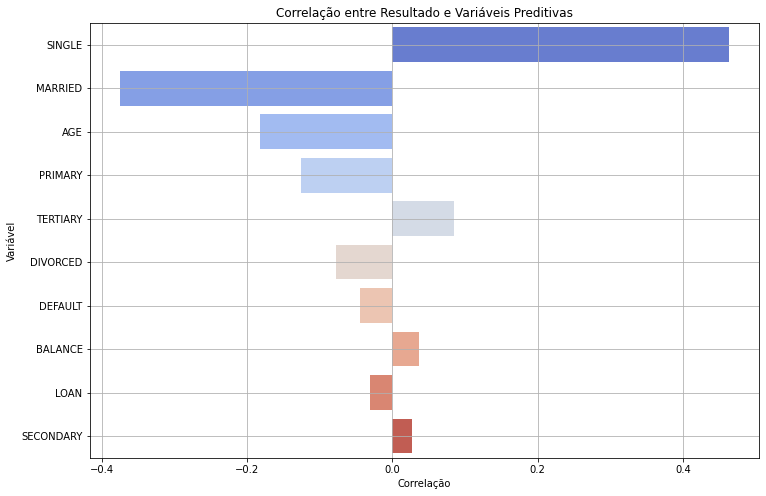

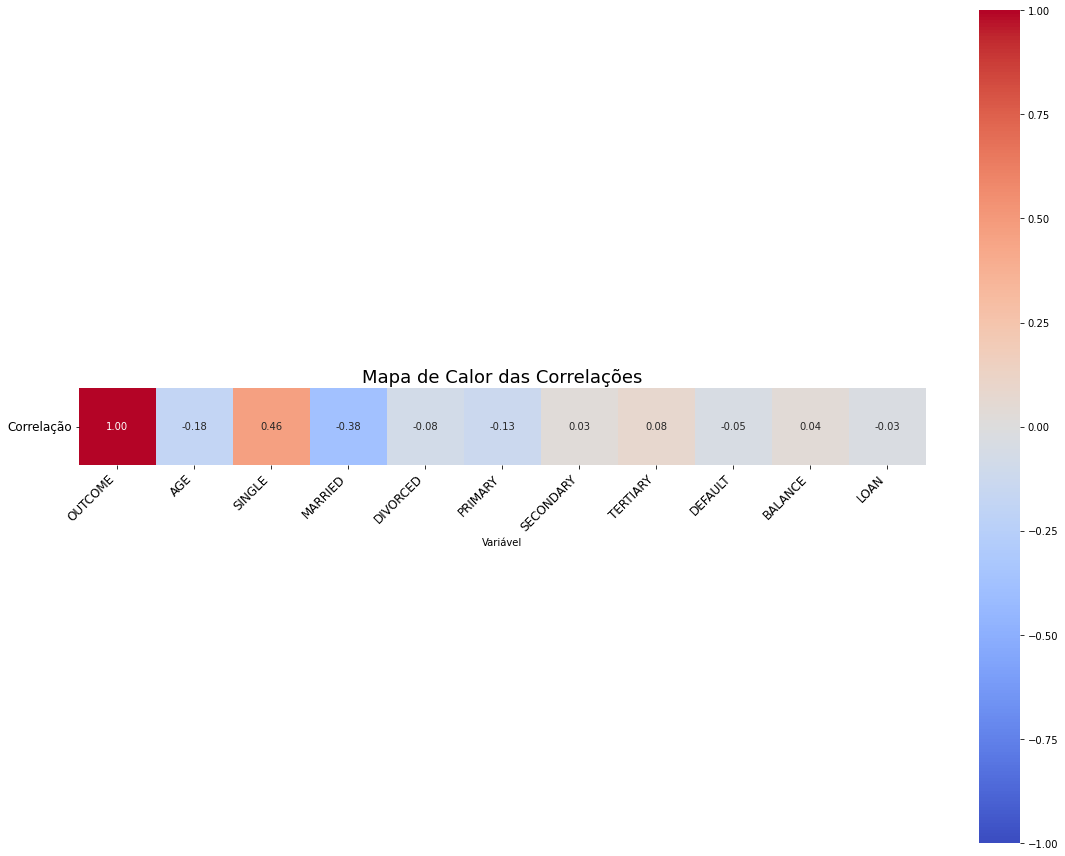

In [15]:
# Correlação entre a variável target (idx_resultado) e as variáveis preditoras
correlations = {}
for col in bankDF.columns:
    if not(isinstance(bankDF.select(col).take(1)[0][0], str)):
        correlations[col] = bankDF.stat.corr('OUTCOME', col)

# Convertendo o dicionário de correlações para um DataFrame Pandas
corr_df = pd.DataFrame(list(correlations.items()), columns=['Variável', 'Correlação'])

# Excluir a variável 'idx_resultado' para o gráfico de barras
corr_df_barras = corr_df[corr_df['Variável'] != 'OUTCOME'].copy()

# Ordenando o DataFrame por correlação absoluta para melhor visualização
corr_df_barras['Abs_Correlação'] = corr_df_barras['Correlação'].abs()
corr_df_barras = corr_df_barras.sort_values(by='Abs_Correlação', ascending=False).drop(columns='Abs_Correlação')

# Criando o gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(x=corr_df_barras['Correlação'], y=corr_df_barras['Variável'], palette='coolwarm')
plt.xlabel('Correlação')
plt.ylabel('Variável')
plt.title('Correlação entre Resultado e Variáveis Preditivas')
plt.grid(True)
plt.show()

# Criação do heatmap da matriz de correlação incluindo a variável 'idx_resultado'
corr_matrix = pd.DataFrame(list(correlations.items()), columns=['Variável', 'Correlação']).set_index('Variável').T

plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, cbar=True, square=True, annot_kws={"size": 10})
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=12)
plt.title('Mapa de Calor das Correlações', fontsize=18)
plt.tight_layout()
plt.show()

<br><br><br>

# <span style="color: green; font-size: 38px; font-weight: bold;">Engenharia de Atributos</span>

<br>

- Nesta etapa também vamos usar a técnica **técnica de Vetores Densos** para a criação dos vetores de características com os valores de todas as variáveis exceto a variável alvo `OUTCOME`.
> (<i>Os vetores densos são mais eficientes e apropriados quando a maioria dos valores são diferentes de zero</i>).

<br>

#### Aplicando Vector Dense e Convertendo para Objeto RDD

In [16]:
# Criando um LabeledPoint (target, Vector[features])
def transformaVar(row) :
    obj = (row["OUTCOME"], Vectors.dense([row["AGE"], 
                                          row["BALANCE"], 
                                          row["DEFAULT"], 
                                          row["DIVORCED"], 
                                          row["LOAN"], 
                                          row["MARRIED"], 
                                          row["PRIMARY"], 
                                          row["SECONDARY"], 
                                          row["SINGLE"], 
                                          row["TERTIARY"]]))
    return obj

# Aplica a função
bankRDD4 = bankDF.rdd.map(transformaVar)

# Verifica Primeiras Linhas
bankRDD4.take(5)

[(0.0, DenseVector([30.0, 1787.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0])),
 (1.0, DenseVector([33.0, 4789.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0])),
 (1.0, DenseVector([35.0, 1350.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0])),
 (1.0, DenseVector([30.0, 1476.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0])),
 (0.0, DenseVector([59.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]))]

<br>

# Convertendo Para Objeto Dataframe PySpark

- Transformar o RDD em um DataFrame do PySpark para facilitar a aplicação de técnicas de Machine Learning.

> Essa conversão é essencial para utilizar os métodos e algoritmos de Machine Learning disponíveis no PySpark.

#### Estrutura do DataFrame

- **label**: A variável alvo numérica resultante do Label Encoding aplicado à coluna "resultado".
- **features**: Um vetor denso contendo as variáveis preditoras.

#### Nota sobre o nome 'label':

> Não é obrigatório usar o nome **'label'** para a variável alvo. No entanto, 'label' é uma convenção comum, especialmente quando se utiliza as bibliotecas de Machine Learning do PySpark, que esperam encontrar uma coluna com este nome por padrão. Utilizar 'label' facilita a integração e aplicação de modelos predefinidos no PySpark.

<br>

#### Converte o objeto RDD para um DataFrame do Spark

In [17]:
# Converte o RDD em DataFrame
bankDF = spSession.createDataFrame(bankRDD4,["label", "features"])

bankDF.cache()

DataFrame[label: double, features: vector]

In [18]:
# Visualiza primeiras linhas
bankDF.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[30.0,1787.0,0.0,...|
|  1.0|[33.0,4789.0,0.0,...|
|  1.0|[35.0,1350.0,0.0,...|
|  1.0|[30.0,1476.0,0.0,...|
|  0.0|[59.0,0.0,0.0,0.0...|
+-----+--------------------+
only showing top 5 rows



<br><br><br><br>

# Pré-Processamento de Dados Para Construção de Modelos de Machine Learning

<br><br>

## Redução de Dimensionalidade com PCA

A redução de dimensionalidade deve ser aplicada quando o número de vaiáveis preditoras for muito alto.

A redução de dimensionalidade é uma técnica usada para reduzir o número de variáveis preditoras em um conjunto de dados. Isso é útil quando se trabalha com um grande número de variáveis, pois pode simplificar o modelo, reduzir o tempo de processamento e ajudar a evitar o overfitting (quando o modelo se ajusta demais aos dados de treinamento e não generaliza bem para novos dados).

<br>

In [19]:
# Cria o objeto PCA com 3 componentes
bankPCA = PCA(k = 3, inputCol = "features", outputCol = "pcaFeatures")

# Treina o modelo
pcaModel = bankPCA.fit(bankDF)

# Aplica o modelo PCA para reduzir a dimensionalidade
pcaResult = pcaModel.transform(bankDF).select("label", "pcaFeatures")

# Visualiza o Resultado
pcaResult.show(truncate = False)

+-----+------------------------------------------------------------+
|label|pcaFeatures                                                 |
+-----+------------------------------------------------------------+
|0.0  |[-1787.018897197381,28.86209683775529,-0.06459982604876241] |
|1.0  |[-4789.020177138492,29.922562636341947,-0.9830243513096373] |
|1.0  |[-1350.022213163262,34.10110809796688,0.8951427168301704]   |
|1.0  |[-1476.0189517184556,29.051333993596703,0.3952723868021948] |
|0.0  |[-0.037889185366442445,58.9897182000177,-0.7290792383661886]|
|1.0  |[-747.0223377634923,34.48829198181773,0.9045654956970108]   |
|1.0  |[-307.0230691022593,35.799850539655225,0.5170631523785976]  |
|0.0  |[-147.0250121617634,38.90107856650329,-0.8069627548799397]  |
|0.0  |[-221.02629853487866,40.853633675694944,0.5373036365803221] |
|1.0  |[87.9723868768871,43.062659441151055,-0.0670164287117152]   |
|0.0  |[-9374.023105550941,32.97645883799288,-0.9511484606914431]  |
|0.0  |[-264.02755731528384,42.824

### Resumo

> A informação contida nas variáveis preditoras está agora consolidada em 3 componentes, para cada linha.

- A PCA foi utilizada para reduzir o número de variáveis preditoras em `bankDF` para apenas 3 componentes principais. Esses componentes principais capturam a maior parte da variação dos dados originais, permitindo que se trabalhe com um conjunto de dados mais compacto e gerenciável sem perder muita informação. Agora, ao invés de trabalhar com um grande número de variáveis preditoras, podemos usar apenas essas 3 componentes principais para fazer previsões.

<br>

## StringIndexer na Variável Alvo

#### O que será feito ?

- **Criação de uma Nova Coluna**: Uma nova coluna chamada label_indexed foi criada. Esta coluna foi gerada a partir da coluna original label, e contém exatamente os mesmos valores (0.0 e 1.0).

- **Motivo da Criação**: A criação da coluna label_indexed é necessária para garantir que os dados estejam no formato esperado por alguns algoritmos de Machine Learning no PySpark, como as árvores de decisão. Embora a coluna label já estivesse numérica, o processo de indexação assegura que ela seja tratada de forma adequada como variável categórica.

In [20]:
# Indexação do label é pré-requisito para Decision Trees
stringIndexer = StringIndexer(inputCol = "label", outputCol = "label_indexed")
si_model = stringIndexer.fit(pcaResult)
obj_final = si_model.transform(pcaResult)
type(obj_final.collect())

list

In [21]:
# Visualiza
obj_final.show(5)

+-----+--------------------+-------------+
|label|         pcaFeatures|label_indexed|
+-----+--------------------+-------------+
|  0.0|[-1787.0188971973...|          0.0|
|  1.0|[-4789.0201771384...|          1.0|
|  1.0|[-1350.0222131632...|          1.0|
|  1.0|[-1476.0189517184...|          1.0|
|  0.0|[-0.0378891853664...|          0.0|
+-----+--------------------+-------------+
only showing top 5 rows



<br>

## Dividindo os dados em Dados de Treino e Dados de Teste
- Nós **treinamos** o modelo com **dados de treino** e **avaliamos** o modelo com **dados de teste**.

<br>

In [22]:
# Dados de Treino e de Teste
(dados_treino, dados_teste) = obj_final.randomSplit([0.7, 0.3])

print(dados_treino.count())
print(dados_teste.count())

381
160


<br><br><br><br><br>

<span style="color: green; font-size: 40px; font-weight: bold;">Construindo Modelos de Machine Learning</span>

<br>

- Nesta etapa do projeto o ideal é escolher um algoritmo simples e fácil de compreender, que será usado como Benchmark (modelo base).

#### Importante

- Iremos treinar dois conjuntos de dados: um **conjunto de dados sem tratamento de escala** e outro **com tratamento de escala**.

<br><br><br>

## Criando Dataframe para salvar métricas de cada Modelo

In [23]:
# Cria um dataframe para receber as métricas de cada modelo
df_modelos = pd.DataFrame()

<br><br><br>

# <span style="color: green; font-weight: bold;">Modelo 1 com Regressão Logística (Benchmark)</span>

<br>

> # Versão 1

- Sem Ajuste de Hiperparâmetros


<br>

### Criação, Treinamento, Previsão e Avaliação do Modelo

In [24]:
# Criar o modelo de regressão logística
lr = LogisticRegression(labelCol="label", featuresCol="pcaFeatures", maxIter=10)

# Treinar o modelo com os dados de treino
lr_model = lr.fit(dados_treino)

# Realizar previsões com os dados de teste
predictions = lr_model.transform(dados_teste)

# Avaliar o modelo
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print the metrics
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Criar um DataFrame para salvar as métricas
modelo_v1_metrics = pd.DataFrame({
    'Nome do Modelo': ['Regressão Logística'],
    'Versao': ['1'],
    'Tipo de Dados': ['PCA Features'],
    'Tipo de Modelo': ['Sem Ajuste de Hiperparâmetros'], 
    'Acurácia': [f"{accuracy:.4f}"],
    'Precisão': [f"{precision:.4f}"],
    'Recall': [f"{recall:.4f}"],
    'F1-Score': [f"{f1:.4f}"]
})

# Concatenando com o DataFrame existente
df_modelos = pd.concat([df_modelos, modelo_v1_metrics], ignore_index=True)

# Visualizando DataFrame
df_modelos

Acurácia: 0.6188
Precisão: 0.6096
Recall: 0.6187
F1-Score: 0.5759


,Nome do Modelo,Versao,Tipo de Dados,Tipo de Modelo,Acurácia,Precisão,Recall,F1-Score
0,Regressão Logística,1,PCA Features,Sem Ajuste de Hiperparâmetros,0.6188,0.6096,0.6187,0.5759


<br><br><br>

# <span style="color: green; font-weight: bold;">Modelo 2 com RandomForestClassifier</span>

<br>

> # Versão 1

- Sem Ajuste de Hiperparâmetros


<br>

### Criação, Treinamento, Previsão e Avaliação do Modelo

In [25]:
# Criar o modelo RandomForest
rf = RandomForestClassifier(labelCol="label", featuresCol="pcaFeatures", numTrees=100)

# Treinar o modelo com os dados de treino
rf_model = rf.fit(dados_treino)

# Realizar previsões com os dados de teste
rf_predictions = rf_model.transform(dados_teste)

# Avaliar o modelo
accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})

# Salvar as métricas
rf_metrics = pd.DataFrame({
    'Nome do Modelo': ['Random Forest'],
    'Versao': ['1'],
    'Tipo de Dados': ['PCA Features'],
    'Tipo de Modelo': ['Sem Ajuste de Hiperparâmetros'], 
    'Acurácia': [f"{accuracy:.4f}"],
    'Precisão': [f"{precision:.4f}"],
    'Recall': [f"{recall:.4f}"],
    'F1-Score': [f"{f1:.4f}"]
})

df_modelos = pd.concat([df_modelos, rf_metrics], ignore_index=True)

# Visualizando DataFrame
df_modelos

,Nome do Modelo,Versao,Tipo de Dados,Tipo de Modelo,Acurácia,Precisão,Recall,F1-Score
0,Regressão Logística,1,PCA Features,Sem Ajuste de Hiperparâmetros,0.6188,0.6096,0.6187,0.5759
1,Random Forest,1,PCA Features,Sem Ajuste de Hiperparâmetros,0.7063,0.7334,0.7063,0.6763


> # Versão 2

- Sem Ajuste de Hiperparâmetros
- Usando a coluna `label_indexed`


<br>

### Criação, Treinamento, Previsão e Avaliação do Modelo

In [26]:
# Criar o modelo RandomForest
rf = RandomForestClassifier(labelCol="label_indexed", featuresCol="pcaFeatures", numTrees=100)

# Treinar o modelo com os dados de treino
rf_model = rf.fit(dados_treino)

# Realizar previsões com os dados de teste
rf_predictions = rf_model.transform(dados_teste)

# Avaliar o modelo
accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})

# Salvar as métricas
rf_metrics = pd.DataFrame({
    'Nome do Modelo': ['Random Forest'],
    'Versao': ['2'],
    'Tipo de Dados': ['PCA Features'],
    'Tipo de Modelo': ['Sem Ajuste de Hiperparâmetros / Usando coluna "label_indexed"'], 
    'Acurácia': [f"{accuracy:.4f}"],
    'Precisão': [f"{precision:.4f}"],
    'Recall': [f"{recall:.4f}"],
    'F1-Score': [f"{f1:.4f}"]
})

df_modelos = pd.concat([df_modelos, rf_metrics], ignore_index=True)

# Visualizando DataFrame
df_modelos

,Nome do Modelo,Versao,Tipo de Dados,Tipo de Modelo,Acurácia,Precisão,Recall,F1-Score
0,Regressão Logística,1,PCA Features,Sem Ajuste de Hiperparâmetros,0.6188,0.6096,0.6187,0.5759
1,Random Forest,1,PCA Features,Sem Ajuste de Hiperparâmetros,0.7063,0.7334,0.7063,0.6763
2,Random Forest,2,PCA Features,Sem Ajuste de Hiperparâmetros / Usando coluna ...,0.7063,0.7334,0.7063,0.6763


<br><br><br>

# <span style="color: green; font-weight: bold;">Modelo 3 com DecisionTreeClassifier</span>

<br>

> # Versão 1

- Sem Ajuste de Hiperparâmetros


<br>

### Criação, Treinamento, Previsão e Avaliação do Modelo

In [27]:
# Criar o modelo DecisionTree
dt = DecisionTreeClassifier(labelCol="label", featuresCol="pcaFeatures")

# Treinar o modelo com os dados de treino
dt_model = dt.fit(dados_treino)

# Realizar previsões com os dados de teste
dt_predictions = dt_model.transform(dados_teste)

# Avaliar o modelo
accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(dt_predictions, {evaluator.metricName: "f1"})

# Salvar as métricas
dt_metrics = pd.DataFrame({
    'Nome do Modelo': ['Decision Tree'],
    'Versao': ['1'],
    'Tipo de Dados': ['PCA Features'],
    'Tipo de Modelo': ['Sem Ajuste de Hiperparâmetros'], 
    'Acurácia': [f"{accuracy:.4f}"],
    'Precisão': [f"{precision:.4f}"],
    'Recall': [f"{recall:.4f}"],
    'F1-Score': [f"{f1:.4f}"]
})

df_modelos = pd.concat([df_modelos, dt_metrics], ignore_index=True)

# Visualizando DataFrame
df_modelos

,Nome do Modelo,Versao,Tipo de Dados,Tipo de Modelo,Acurácia,Precisão,Recall,F1-Score
0,Regressão Logística,1,PCA Features,Sem Ajuste de Hiperparâmetros,0.6188,0.6096,0.6187,0.5759
1,Random Forest,1,PCA Features,Sem Ajuste de Hiperparâmetros,0.7063,0.7334,0.7063,0.6763
2,Random Forest,2,PCA Features,Sem Ajuste de Hiperparâmetros / Usando coluna ...,0.7063,0.7334,0.7063,0.6763
3,Decision Tree,1,PCA Features,Sem Ajuste de Hiperparâmetros,0.6875,0.6959,0.6875,0.6630


<br><br><br>

# <span style="color: green; font-weight: bold;">Modelo 4 com GradientBoostedTreeClassifier</span>

<br>

> # Versão 1

- Sem Ajuste de Hiperparâmetros


<br>

### Criação, Treinamento, Previsão e Avaliação do Modelo

In [28]:
# Criar o modelo GradientBoostedTree
gbt = GBTClassifier(labelCol="label", featuresCol="pcaFeatures", maxIter=100)

# Treinar o modelo com os dados de treino
gbt_model = gbt.fit(dados_treino)

# Realizar previsões com os dados de teste
gbt_predictions = gbt_model.transform(dados_teste)

# Avaliar o modelo
accuracy = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "f1"})

# Salvar as métricas
gbt_metrics = pd.DataFrame({
    'Nome do Modelo': ['Gradient Boosted Tree'],
    'Versao': ['1'],
    'Tipo de Dados': ['PCA Features'],
    'Tipo de Modelo': ['Sem Ajuste de Hiperparâmetros'], 
    'Acurácia': [f"{accuracy:.4f}"],
    'Precisão': [f"{precision:.4f}"],
    'Recall': [f"{recall:.4f}"],
    'F1-Score': [f"{f1:.4f}"]
})

df_modelos = pd.concat([df_modelos, gbt_metrics], ignore_index=True)

# Visualizando DataFrame
df_modelos

,Nome do Modelo,Versao,Tipo de Dados,Tipo de Modelo,Acurácia,Precisão,Recall,F1-Score
0,Regressão Logística,1,PCA Features,Sem Ajuste de Hiperparâmetros,0.6188,0.6096,0.6187,0.5759
1,Random Forest,1,PCA Features,Sem Ajuste de Hiperparâmetros,0.7063,0.7334,0.7063,0.6763
2,Random Forest,2,PCA Features,Sem Ajuste de Hiperparâmetros / Usando coluna ...,0.7063,0.7334,0.7063,0.6763
3,Decision Tree,1,PCA Features,Sem Ajuste de Hiperparâmetros,0.6875,0.6959,0.6875,0.6630
4,Gradient Boosted Tree,1,PCA Features,Sem Ajuste de Hiperparâmetros,0.6625,0.6565,0.6625,0.6506


In [29]:
# Carregando os dados e gerando um RDD com 2 partições
spamRDD = sc.textFile("Lab/dados/dataset4.csv", 2)

In [34]:
spamRDD.take(24)

['ham,Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...,,,,,,,,,',
 'ham,Ok lar... Joking wif u oni...,,,,,,,,,,',
 'ham,U dun say so early hor... U c already then say...,,,,,,,,,,',
 "ham,Nah I don't think he goes to usf, he lives around here though,,,,,,,,,",
 'ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,,,,,,,,',
 "ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,,,,,,,,",
 "ham,I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.,,,,,,,,,",
 "ham,I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.,,,,,,,,,,",
 'ham,I HAVE A DATE ON SUNDAY WITH WILL!!,,,,,,,,,,',
 "ham